## Data Preprocessing
Suprita Ashok

Following is the same data exploration data_exploration.ipynb

## Import Libraries and Dataset

In [1]:
import kagglehub
import numpy as np
import pandas as pd

from tabulate import tabulate
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import seaborn as sns
from textblob import TextBlob

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
import string
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import nltk

# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/fake-news-detection")

print("Path to dataset files:", path)

# load datasets
fake=pd.read_csv(path+'/fake.csv')
true=pd.read_csv(path+'/true.csv')

100%|██████████| 41.0M/41.0M [00:02<00:00, 14.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bhavikjikadara/fake-news-detection/versions/1


## Preliminary Inspection and Word Clouds

- All/most of the true data was likely sourced from Reuters

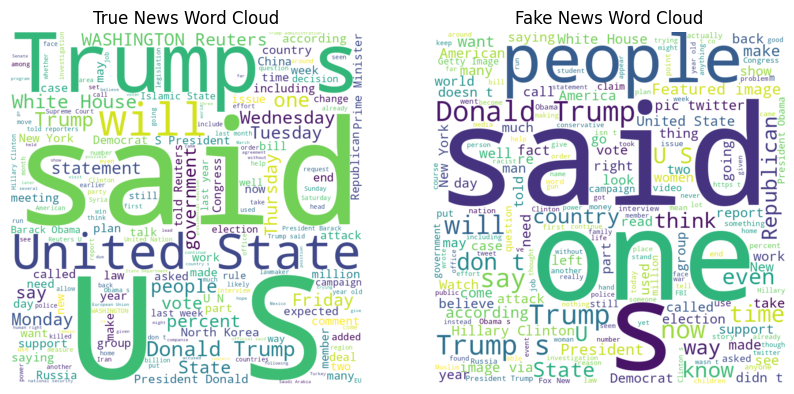

In [4]:
true_text = ' '.join(true['text'].astype(str))
fake_text = ' '.join(fake['text'].astype(str))

true_wordcloud = WordCloud(width=800, height=800, background_color='white').generate(true_text)
fake_wordcloud = WordCloud(width=800, height=800, background_color='white').generate(fake_text)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(true_wordcloud, interpolation='bilinear')
plt.axis('off')
plt
plt.title('True News Word Cloud')

plt.subplot(1, 2, 2)
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News Word Cloud')

plt.show()

In [ ]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
true.tail()

,title,text,subject,date
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"
21416,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017"


In [ ]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
fake.tail()

,title,text,subject,date
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016"


## Dataset Balance, Features, Missing Values, Duplicates

Summary of findings:
- The dataset is well balanced, with 21417 true news articles, and 23481 fake news articles
- There are four features: title, text, subject and date
- There is no missing (NaN) data
- There are no articles without titles
- There are some articles without text
- There is some duplicate data: 206 duplicated true news articles, and 3 duplicated fake news articles

The articles without titles and the duplicate articles were dropped from the datasets.

True news dataset shape: (21417, 4)
Fake news dataset shape: (23481, 4)


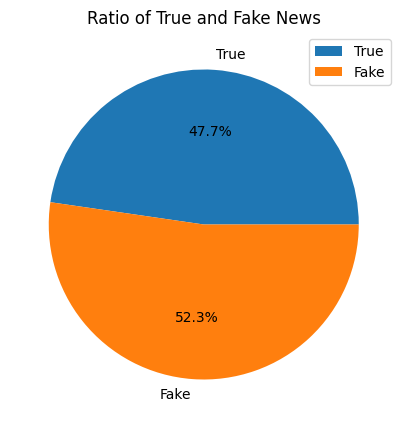

Features in 'True' Dataset:
 ['title', 'text', 'subject', 'date'] 

Features in 'Fake' Dataset:
 ['title', 'text', 'subject', 'date'] 



In [ ]:
# Print shape
print("True news dataset shape:",true.shape)
print("Fake news dataset shape:",fake.shape)

# Graph pie chart displaying ratio of true and fake news
plt.figure(figsize=(5,5))
plt.title('Ratio of True and Fake News')
plt.axis('equal')
plt.pie([true.shape[0],fake.shape[0]],labels=['True','Fake'],autopct='%1.1f%%')
plt.legend()
plt.show()

# Print feature names (column names) for both datasets
print("Features in 'True' Dataset:\n", true.columns.tolist(), "\n")
print("Features in 'Fake' Dataset:\n", fake.columns.tolist(), "\n")

In [ ]:
# Summary of blank and missing entries in true data
summary_true = {
    "Blank Text Entries": (true['text'].str.strip() == '').sum(),
    "Blank Title Entries": (true['title'].str.strip() == '').sum(),
    "Missing Entries (NaN)": true.isna().sum().sum(),
}

# Convert dictionary to a DataFrame for better tabulation
summary_df = pd.DataFrame(list(summary_true.items()), columns=["Entry Type", "Count"])

# Display the summary in tabular format
print(tabulate(summary_df, headers="keys", tablefmt="grid"))

+----+-----------------------+---------+
|    | Entry Type            |   Count |
+====+=======================+=========+
|  0 | Blank Text Entries    |       1 |
+----+-----------------------+---------+
|  1 | Blank Title Entries   |       0 |
+----+-----------------------+---------+
|  2 | Missing Entries (NaN) |       0 |
+----+-----------------------+---------+


In [ ]:
summary_fake = {
    "Blank Text Entries": (fake['text'].str.strip() == '').sum(),
    "Blank Title Entries": (fake['title'].str.strip() == '').sum(),
    "Missing Entries (NaN)": fake.isna().sum().sum(),
}

# Convert dictionary to a DataFrame for better tabulation
summary_df = pd.DataFrame(list(summary_fake.items()), columns=["Entry Type", "Count"])

# Display the summary in tabular format
print(tabulate(summary_df, headers="keys", tablefmt="grid"))

+----+-----------------------+---------+
|    | Entry Type            |   Count |
+====+=======================+=========+
|  0 | Blank Text Entries    |     630 |
+----+-----------------------+---------+
|  1 | Blank Title Entries   |       0 |
+----+-----------------------+---------+
|  2 | Missing Entries (NaN) |       0 |
+----+-----------------------+---------+


In [ ]:
# Identify duplicates for both datasets
true_duplicates = true.duplicated().sum()
fake_duplicates = fake.duplicated().sum()

print("Number of Duplicates in 'True' Dataset:", true_duplicates)
print("Number of Duplicates in 'Fake' Dataset:", fake_duplicates)

Number of Duplicates in 'True' Dataset: 206
Number of Duplicates in 'Fake' Dataset: 3


In [5]:
# Drop duplicates
true = true.drop_duplicates()
fake = fake.drop_duplicates()

# Drop articles without text
indices = true[(true['text'].str.strip() == '')].index
true_cleaned = true.drop(indices)

indices = fake[(fake['text'].str.strip() == '')].index
fake_cleaned = fake.drop(indices)

# Print shape
print("True news dataset shape:",true.shape)
print("Fake news dataset shape:",fake.shape)

True news dataset shape: (21211, 4)
Fake news dataset shape: (23478, 4)


## Word Frequency Analysis (Text Only, Did Not Include Titles)

After dropping duplicate articles, the top ten most frequent words in text, after removing the most common stopwords, were identified for both true and fake news. Also, the top ten most divergent word frequencies between true and fake news were identified.


Top 10 Fake Words:
['trump', 'said', 'president', 'people', 'just', 'clinton', 'obama', 'like', 'donald', 'news']

Top 10 True Words:
['said', 'trump', 'reuters', 'president', 'state', 'government', 'new', 'house', 'states', 'republican']

Top 10 Divergent Words:
['said', 'reuters', 'government', 'minister', 'china', 'united', 'state', 'washington', 'north', 'republican']


In [ ]:
true_text = ' '.join(true['text'].astype(str))
fake_text = ' '.join(fake['text'].astype(str))
all_text = [true_text, fake_text]

# Initialize CountVectorizer with stopword removal
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the data
true_counts = vectorizer.fit_transform([true_text])
fake_counts = vectorizer.fit_transform([fake_text])

# Fit on all text and transform each text separately
vectorizer.fit(all_text)
true_counts = vectorizer.transform([true_text])
fake_counts = vectorizer.transform([fake_text])

# Convert to DataFrames
true_word_freq = pd.DataFrame(true_counts.toarray(), columns=vectorizer.get_feature_names_out()).T
fake_word_freq = pd.DataFrame(fake_counts.toarray(), columns=vectorizer.get_feature_names_out()).T

# Add column names for clarity
true_word_freq.columns = ['Frequency']
fake_word_freq.columns = ['Frequency']

# Get top 10 most frequent words for true and fake news
top_true = true_word_freq.sort_values(by='Frequency', ascending=False).head(10)
top_fake = fake_word_freq.sort_values(by='Frequency', ascending=False).head(10)

In [ ]:
# Display top 10 most frequent words for true news
print("Top 10 Most Frequent Words in True News:")
print(tabulate(top_true.reset_index(), headers=['Word', 'Frequency'], tablefmt='grid'))

Top 10 Most Frequent Words in True News:
+----+------------+-------------+
|    | Word       |   Frequency |
+====+============+=============+
|  0 | said       |       97867 |
+----+------------+-------------+
|  1 | trump      |       54098 |
+----+------------+-------------+
|  2 | reuters    |       28681 |
+----+------------+-------------+
|  3 | president  |       27879 |
+----+------------+-------------+
|  4 | state      |       20808 |
+----+------------+-------------+
|  5 | government |       18552 |
+----+------------+-------------+
|  6 | new        |       16758 |
+----+------------+-------------+
|  7 | house      |       16492 |
+----+------------+-------------+
|  8 | states     |       16422 |
+----+------------+-------------+
|  9 | republican |       16149 |
+----+------------+-------------+


In [ ]:
# Display top 10 most frequent words for fake news
print("\nTop 10 Most Frequent Words in Fake News:")
print(tabulate(top_fake.reset_index(), headers=['Word', 'Frequency'], tablefmt='grid'))


Top 10 Most Frequent Words in Fake News:
+----+-----------+-------------+
|    | Word      |   Frequency |
+====+===========+=============+
|  0 | trump     |       79300 |
+----+-----------+-------------+
|  1 | said      |       33762 |
+----+-----------+-------------+
|  2 | president |       27714 |
+----+-----------+-------------+
|  3 | people    |       26570 |
+----+-----------+-------------+
|  4 | just      |       20508 |
+----+-----------+-------------+
|  5 | clinton   |       19168 |
+----+-----------+-------------+
|  6 | obama     |       18797 |
+----+-----------+-------------+
|  7 | like      |       18096 |
+----+-----------+-------------+
|  8 | donald    |       17671 |
+----+-----------+-------------+
|  9 | news      |       14620 |
+----+-----------+-------------+


Compare frequencies of words between true and fake news:

In [ ]:
# Combine and compare frequencies
comparison = pd.concat([true_word_freq, fake_word_freq], axis=1, keys=['True', 'Fake']).fillna(0)
comparison.columns = ['True_Frequency', 'Fake_Frequency']
comparison['Difference'] = comparison['True_Frequency'] - comparison['Fake_Frequency']

# Get top 10 most divergent words
top_divergent = comparison.sort_values(by='Difference', ascending=False).head(10)

# Display results with tabulate
print("Top 10 Most Divergent Words:")
print(tabulate(top_divergent.reset_index(), headers=['Word', 'True_Frequency', 'Fake_Frequency', 'Difference'], tablefmt='grid'))

Top 10 Most Divergent Words:
+----+------------+------------------+------------------+--------------+
|    | Word       |   True_Frequency |   Fake_Frequency |   Difference |
+====+============+==================+==================+==============+
|  0 | said       |            97867 |            33762 |        64105 |
+----+------------+------------------+------------------+--------------+
|  1 | reuters    |            28681 |              449 |        28232 |
+----+------------+------------------+------------------+--------------+
|  2 | government |            18552 |             9201 |         9351 |
+----+------------+------------------+------------------+--------------+
|  3 | minister   |             8549 |              984 |         7565 |
+----+------------+------------------+------------------+--------------+
|  4 | china      |             8719 |             1254 |         7465 |
+----+------------+------------------+------------------+--------------+
|  5 | united     |   

In [ ]:
# Print list of top ten fake words
print("\nTop 10 Fake Words:")
print(top_fake.index.tolist())

# Print list of top ten true words
print("\nTop 10 True Words:")
print(top_true.index.tolist())

# Print list of top ten words
print("\nTop 10 Divergent Words:")
print(top_divergent.index.tolist())


Top 10 Fake Words:
['trump', 'said', 'president', 'people', 'just', 'clinton', 'obama', 'like', 'donald', 'news']

Top 10 True Words:
['said', 'trump', 'reuters', 'president', 'state', 'government', 'new', 'house', 'states', 'republican']

Top 10 Divergent Words:
['said', 'reuters', 'government', 'minister', 'china', 'united', 'state', 'washington', 'north', 'republican']


## Data Exploration (continued)
Vrinda Pandey

Below is an alaysis of the titles of True and Fake news examining the words, their usage, frequency and furthermore the ideas these words may imply in the recspecitve news pieces. At the end you can find a summary and ideas that should be further investigated

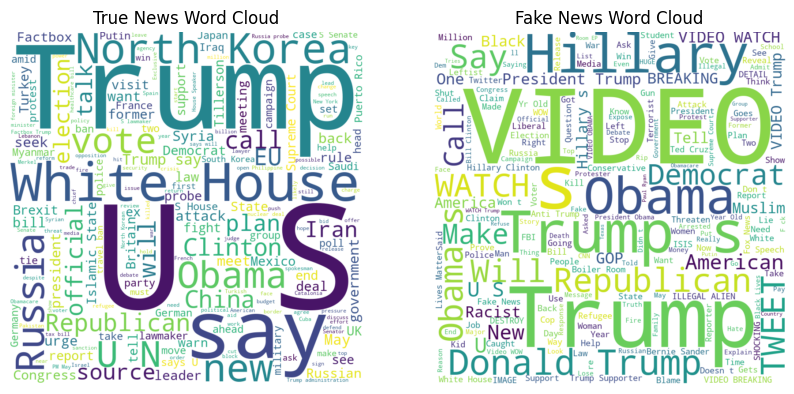

In [ ]:
true_title = ' '.join(true['title'].astype(str))
fake_title = ' '.join(fake['title'].astype(str))

true_title_wordcloud = WordCloud(width=800, height=800, background_color='white').generate(true_title)
fake_title_wordcloud = WordCloud(width=800, height=800, background_color='white').generate(fake_title)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(true_title_wordcloud, interpolation='bilinear')
plt.axis('off')
plt
plt.title('True News Word Titles Cloud')

plt.subplot(1, 2, 2)
plt.imshow(fake_title_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News Titles Word Cloud')

plt.show()

In [ ]:
all_text = [true_title, fake_title]

# Initialize CountVectorizer with stopword removal
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the data
true_counts = vectorizer.fit_transform([true_title])
fake_counts = vectorizer.fit_transform([fake_title])

# Fit on all text and transform each text separately
vectorizer.fit(all_text)
true_counts = vectorizer.transform([true_title])
fake_counts = vectorizer.transform([fake_title])

# Convert to DataFrames
true_word_freq = pd.DataFrame(true_counts.toarray(), columns=vectorizer.get_feature_names_out()).T
fake_word_freq = pd.DataFrame(fake_counts.toarray(), columns=vectorizer.get_feature_names_out()).T

# Add column names for clarity
true_word_freq.columns = ['Frequency']
fake_word_freq.columns = ['Frequency']

# Get top 10 most frequent words for true and fake news
top_true_titles = true_word_freq.sort_values(by='Frequency', ascending=False).head(10)
top_fake_titles = fake_word_freq.sort_values(by='Frequency', ascending=False).head(10)

In [ ]:
# Display top 10 most frequent words for true news titles
print("Top 10 Most Frequent Words in True News Titles:")
print(tabulate(top_true_titles.reset_index(), headers=['Word', 'Frequency'], tablefmt='grid'))

Top 10 Most Frequent Words in True News Titles:
+----+--------+-------------+
|    | Word   |   Frequency |
+====+========+=============+
|  0 | trump  |        5518 |
+----+--------+-------------+
|  1 | says   |        2962 |
+----+--------+-------------+
|  2 | house  |        1447 |
+----+--------+-------------+
|  3 | russia |         967 |
+----+--------+-------------+
|  4 | north  |         912 |
+----+--------+-------------+
|  5 | korea  |         887 |
+----+--------+-------------+
|  6 | new    |         871 |
+----+--------+-------------+
|  7 | white  |         815 |
+----+--------+-------------+
|  8 | china  |         777 |
+----+--------+-------------+
|  9 | senate |         756 |
+----+--------+-------------+


In [ ]:
# Display top 10 most frequent words for fake news
print("\nTop 10 Most Frequent Words in Fake News:")
print(tabulate(top_fake_titles.reset_index(), headers=['Word', 'Frequency'], tablefmt='grid'))


Top 10 Most Frequent Words in Fake News:
+----+-----------+-------------+
|    | Word      |   Frequency |
+====+===========+=============+
|  0 | trump     |        9338 |
+----+-----------+-------------+
|  1 | video     |        8474 |
+----+-----------+-------------+
|  2 | obama     |        2582 |
+----+-----------+-------------+
|  3 | hillary   |        2317 |
+----+-----------+-------------+
|  4 | watch     |        1937 |
+----+-----------+-------------+
|  5 | just      |        1409 |
+----+-----------+-------------+
|  6 | president |        1146 |
+----+-----------+-------------+
|  7 | clinton   |        1138 |
+----+-----------+-------------+
|  8 | new       |         905 |
+----+-----------+-------------+
|  9 | black     |         896 |
+----+-----------+-------------+


In [ ]:
# Combine and compare frequencies
comparison = pd.concat([true_word_freq, fake_word_freq], axis=1, keys=['True', 'Fake']).fillna(0)
comparison.columns = ['True_Frequency', 'Fake_Frequency']
comparison['Difference'] = comparison['True_Frequency'] - comparison['Fake_Frequency']

# Get top 10 most divergent words
top_divergent_title = comparison.sort_values(by='Difference', ascending=False).head(10)

# Display results with tabulate
print("Top 10 Most Divergent Words in News Titles:")
print(tabulate(top_divergent_title.reset_index(), headers=['Word', 'True_Frequency', 'Fake_Frequency', 'Difference'], tablefmt='grid'))

Top 10 Most Divergent Words in News Titles:
+----+--------+------------------+------------------+--------------+
|    | Word   |   True_Frequency |   Fake_Frequency |   Difference |
+====+========+==================+==================+==============+
|  0 | says   |             2962 |              561 |         2401 |
+----+--------+------------------+------------------+--------------+
|  1 | house  |             1447 |              552 |          895 |
+----+--------+------------------+------------------+--------------+
|  2 | north  |              912 |              108 |          804 |
+----+--------+------------------+------------------+--------------+
|  3 | korea  |              887 |               85 |          802 |
+----+--------+------------------+------------------+--------------+
|  4 | china  |              777 |               58 |          719 |
+----+--------+------------------+------------------+--------------+
|  5 | russia |              967 |              376 |      

In [ ]:
# Print list of top ten fake words in news titles
print("\nTop 10 Fake Words:")
print(top_fake_titles.index.tolist())

# Print list of top ten true words in news titles
print("\nTop 10 True Words:")
print(top_true_titles.index.tolist())

# Print list of top ten words in news titles
print("\nTop 10 Divergent Words:")
print(top_divergent_title.index.tolist())


Top 10 Fake Words:
['trump', 'video', 'obama', 'hillary', 'watch', 'just', 'president', 'clinton', 'new', 'black']

Top 10 True Words:
['trump', 'says', 'house', 'russia', 'north', 'korea', 'new', 'white', 'china', 'senate']

Top 10 Divergent Words:
['says', 'house', 'north', 'korea', 'china', 'russia', 'senate', 'eu', 'talks', 'tax']


Summary of findings:
-trump is apparently everyones favorite word regardless of fake or true news titles
-true news titleshas a higher frequency of foreign countries mentioned than fake news titles
-fake news has call to action words such as watch and video

Calls of Action:
-one of the top 10 most frequent words in true news titles is white while one of the top 10 most frequent words in fake news titles is black. What does this mean? Is it racial?
-it seemed as if fake news has call to action words such as watch and video. We should investigate if fake news has more of these action verbage as if its asking its audience to do something
-Since most/all true data is from Reuters would be interesting and probably relevant to identify any news biases that reuters has

## Sentiment Analysis

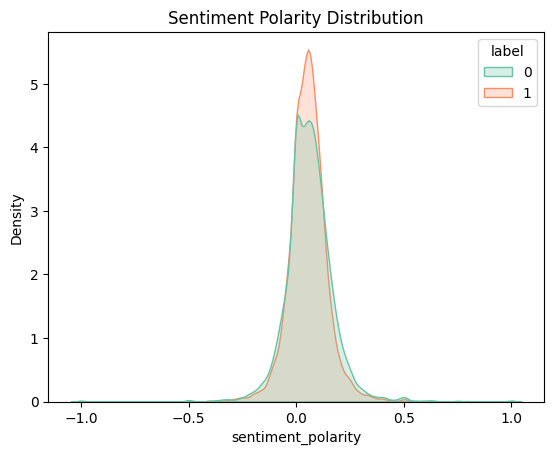

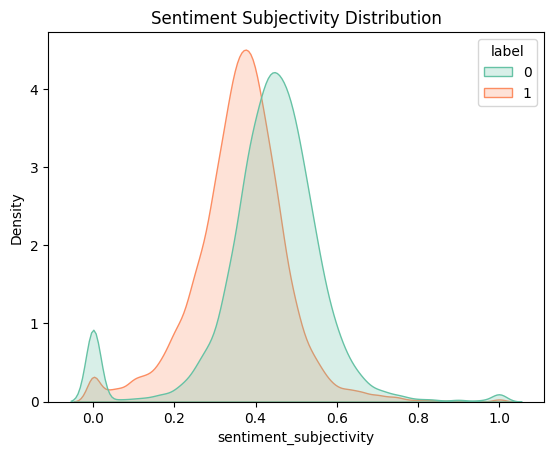

In [6]:
# Add sentiment scores
true['label'] = 1
fake['label'] = 0
all_news = pd.concat([true, fake], ignore_index=True)

all_news['sentiment_polarity'] = all_news['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
all_news['sentiment_subjectivity'] = all_news['text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

# Compare polarity and subjectivity
sns.kdeplot(data=all_news, x='sentiment_polarity', hue='label', fill=True, common_norm=False, palette='Set2')
plt.title("Sentiment Polarity Distribution")
plt.show()

sns.kdeplot(data=all_news, x='sentiment_subjectivity', hue='label', fill=True, common_norm=False, palette='Set2')
plt.title("Sentiment Subjectivity Distribution")
plt.show()

In [7]:
all_news = all_news.sample(frac=1, random_state=42).reset_index(drop=True)
all_news.head()

,title,text,subject,date,label,sentiment_polarity,sentiment_subjectivity
0,"Merkel, Juncker discuss Catalan crisis: EU off...",BRUSSELS (Reuters) - German Chancellor Angela ...,worldnews,"October 7, 2017",1,-0.043269,0.274753
1,LIBERAL HACK KATIE COURIC Says Fake News Is “T...,Katie Couric is a wolf in sheep s clothing. Da...,left-news,"Jul 22, 2017",0,-0.011372,0.488942
2,TRUMP WAS RIGHT! Audit Reveals State Dept. Cyb...,New documents appear to show a pattern of dete...,politics,"Oct 19, 2015",0,-0.019421,0.470868
3,Clay Aiken Says He Was A ‘F*****g Dumbass’ Fo...,Former American Idol finalist and Celebrity...,News,"August 16, 2017",0,-0.076308,0.538999
4,U.S. militia girds for trouble as presidential...,"JACKSON, Ga. (Reuters) - Down a Georgia count...",politicsNews,"November 2, 2016",1,0.042529,0.305690


In [ ]:
print(all_news.isnull().sum())  # Check for NaN in the training labels

title                     0
text                      0
subject                   0
date                      0
label                     0
sentiment_polarity        0
sentiment_subjectivity    0
dtype: int64


In [8]:
# Remove duplicate text entries based on the 'text' column
all_news = all_news.drop_duplicates(subset=['text']).reset_index(drop=True)
print(f"Dataset size after removing duplicate text entries: {all_news.shape}")

Dataset size after removing duplicate text entries: (38646, 7)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(all_news['text'], all_news['label'], test_size=0.2, random_state=42, stratify=all_news['label'])
overlap = set(X_train).intersection(set(X_test))
print(f"Number of overlapping samples between train and test sets: {len(overlap)}")

Number of overlapping samples between train and test sets: 0


In [ ]:
all_news.shape, X_train.shape, X_test.shape

((44689, 7), (35751,), (8938,))

## Preprocessing with NLP

The above code causes the word "U.S." to be turned into "u.s".

The preprocessing needs to be done for all elements in the all_text pd

In [ ]:
# clean text
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Preserve words like U.S. by putting a special character there temporarily
    text = re.sub(r'\b([a-zA-Z])\.(?=[a-zA-Z])', r'\1specialdot', text) # Acronyms (U.S.)
    text = re.sub(r'\b([a-zA-Z])\.(?=\s|$)', r'\1specialdot', text)  # End of sentence

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Restore the periods in words like U.S.
    text = text.replace("specialdot", ".")
    text = re.sub(r'[^\w\s\.specialdot]', '', text)

    # Tokenize text
    tokens = text.split()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into a single string
    processed_text = ' '.join(tokens)
    return processed_text

def vectorize(text):
    vectorizer = TfidfVectorizer(
        max_features=1000,
        ngram_range=(1,1),
        stop_words='english'
    )
    X_tfidf = vectorizer.fit_transform(text)
    return X_tfidf, vectorizer




In [ ]:
# clean
X_train, X_test, y_train, y_test = train_test_split(all_news['text'], all_news['label'], test_size=0.2, random_state=42, stratify=all_news['label'])
X_train, X_test = X_train.apply(preprocess_text), X_test.apply(preprocess_text)
# vectorize
X_train, vectorizer = vectorize(X_train)
X_test = vectorizer.transform(X_test)

# train with a simple rf
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f'Accuracy is: {accuracy_score(y_test, y_pred)}')

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3491
           1       1.00      1.00      1.00      4239

    accuracy                           1.00      7730
   macro avg       1.00      1.00      1.00      7730
weighted avg       1.00      1.00      1.00      7730

0.9963777490297542


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-validation Accuracies:", scores)
print("Average Accuracy:", scores.mean())

Cross-validation Accuracies: [0.99563389 0.99514799 0.99579492 0.99660359 0.99547145]
Average Accuracy: 0.995730369274012
